In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import glob

# files = glob.glob('bucket/stdata/*_stdata.tsv.gz')


In [3]:
train_metadata = pd.read_csv("bucket/train_metadata.csv", index_col = 0)

In [9]:
test_metadata = pd.read_csv("bucket/test_metadata.csv", index_col = 0)

In [10]:
metadata = pd.concat([train_metadata, test_metadata])

In [11]:
files = 'bucket/stdata/' + metadata["count_matrix"]

In [12]:
dataframes = [pd.read_csv(file, sep='\t', index_col = 0, compression='gzip') for file in files]


In [13]:
# Extracting column names from each DataFrame
column_names_list = [set(df.columns) for df in dataframes]

# Finding the intersection of column names
common_columns = set.intersection(*column_names_list)


In [14]:
concatenated_dataframe = pd.concat([df[list(common_columns)] for df in dataframes], axis=0, ignore_index=False)


In [21]:
adata = sc.AnnData(concatenated_dataframe)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [74]:
adata_raw = sc.AnnData(concatenated_dataframe)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


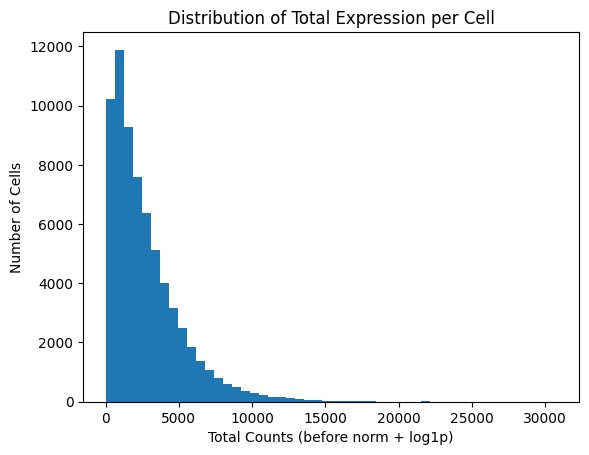

In [22]:
# Plot the histogram of total counts (log-transformed values)
plt.hist(adata.X.sum(axis=1), bins=50)
plt.xlabel('Total Counts (before norm + log1p)')
plt.ylabel('Number of Cells')
plt.title('Distribution of Total Expression per Cell')
plt.show()

In [23]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


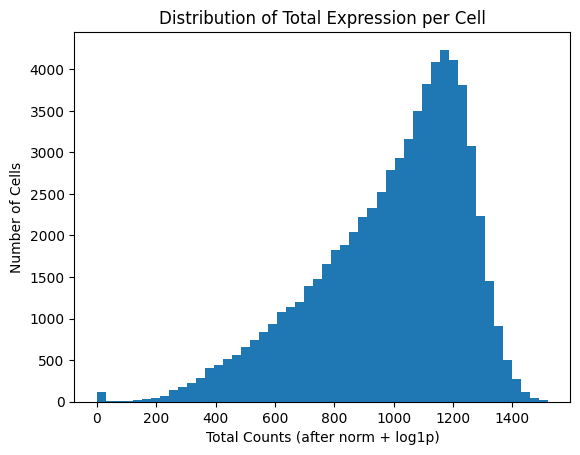

In [24]:
# Plot the histogram of total counts (log-transformed values)
plt.hist(adata.X.sum(axis=1), bins=50)
plt.xlabel('Total Counts (after norm + log1p)')
plt.ylabel('Number of Cells')
plt.title('Distribution of Total Expression per Cell')
plt.show()

In [25]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000) # flavor Seurat

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [26]:
# Access the highly variable genes
top_genes_by_variance = adata.var_names[adata.var['highly_variable']]


In [90]:
# filter out ambiguous genes
top_genes_by_variance_filtered = pd.Index([gene for gene in top_genes_by_variance if '__ambiguous' not in gene])


In [91]:
# Calculate mean expression across samples for each gene
mean_expression_per_gene = adata[:, top_genes_by_variance_filtered].X.mean(axis=0)
top_250_genes = top_genes_by_variance_filtered[mean_expression_per_gene.argsort()[-250:][::-1]]


In [92]:
top_250_genes

Index(['ENSG00000171345', 'ENSG00000149273', 'ENSG00000204628',
       'ENSG00000117984', 'ENSG00000108518', 'ENSG00000166441',
       'ENSG00000185624', 'ENSG00000255823', 'ENSG00000170889',
       'ENSG00000269028',
       ...
       'ENSG00000105397', 'ENSG00000143545', 'ENSG00000213024',
       'ENSG00000099326', 'ENSG00000164855', 'ENSG00000146576',
       'ENSG00000187713', 'ENSG00000104140', 'ENSG00000131242',
       'ENSG00000178814'],
      dtype='object', length=250)

In [93]:
import numpy as np

In [94]:
# save genes to file
np.savetxt('bucket/top_250_genes_new.txt', top_250_genes, fmt='%s')


In [72]:
# save raw and log normed adata to file
adata.write("bucket/log_norm_combined_adata.h5ad")

In [75]:
adata_raw.write("bucket/raw_combined_adata.h5ad")

In [95]:
# save concatenated df to file
concatenated_dataframe[top_250_genes].to_csv("bucket/raw_counts_df_top_250.csv", index = True)

Visualizing selected genes

Convert ensemble id's to gene names

In [98]:
import mygene
import pandas as pd

# Initialize the MyGene.Info query engine
mg = mygene.MyGeneInfo()

# Assuming 'adata_subset.var_names' contains your Ensembl IDs
ensembl_ids = top_250_genes.tolist()

# Query MyGene.Info for HGNC symbols
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Process query results and extract gene symbols, handling missing values if necessary
gene_symbols = {result['query']: result.get('symbol', 'NA') for result in gene_info}


INFO:biothings.client:querying 1-250...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [103]:
gene_symbols['ENSG00000255823'] = "MTRNR2L8"
gene_symbols['ENSG00000269028'] = "MTRNR2L12"
gene_symbols['ENSG00000256618'] = "MTRNR2L1"
gene_symbols['ENSG00000279576'] = "MALAT1"

In [123]:
top_250_genes_hgnc = np.array(list(gene_symbols.values()))
np.savetxt('bucket/top_250_genes_new_hgnc.txt', top_250_genes_hgnc, fmt='%s')


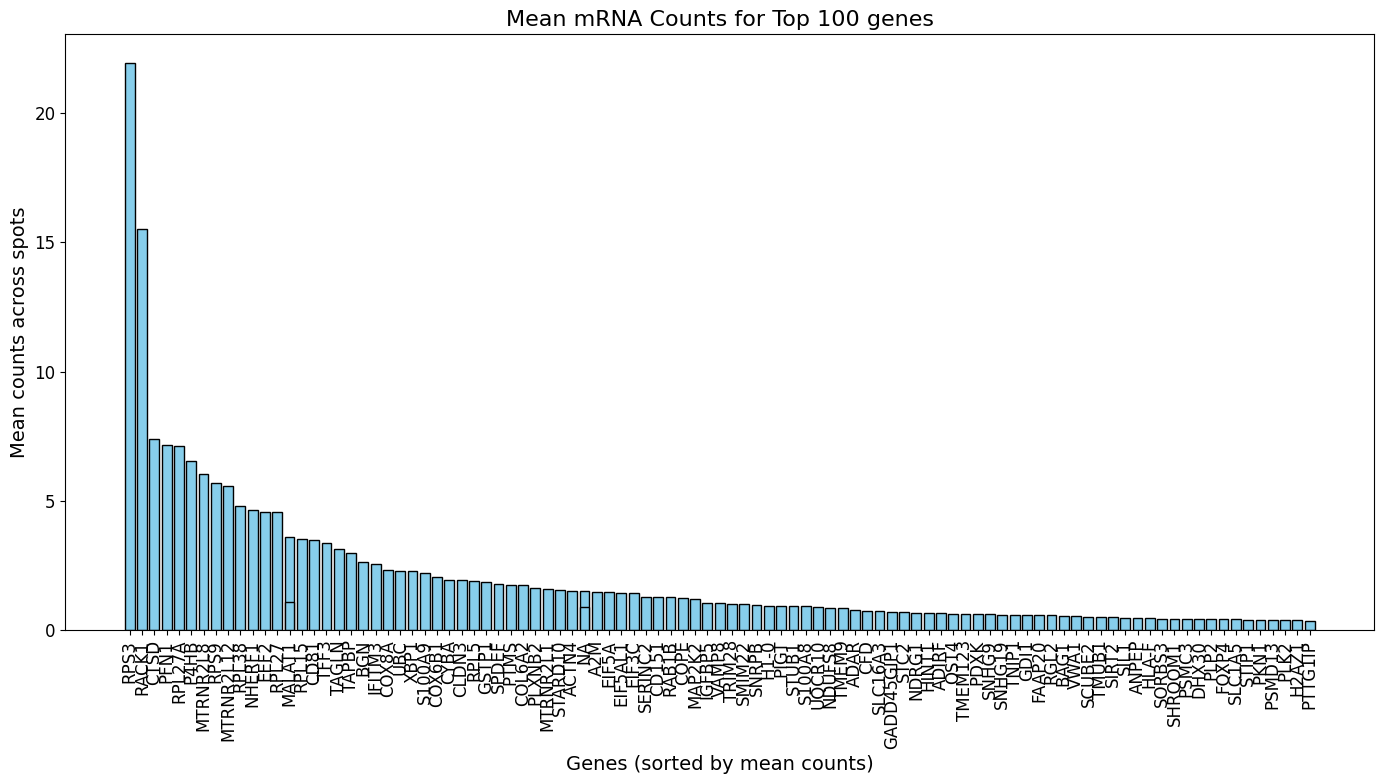

<Figure size 640x480 with 0 Axes>

In [141]:
import matplotlib.pyplot as plt
# mean counts of 250 genes across spots
mean_counts = concatenated_dataframe[top_250_genes[1:100]].mean(axis=0)
mean_counts_sorted = mean_counts.sort_values(ascending = False)

# plot
plt.figure(figsize=(14, 8))
plt.bar(top_250_genes_hgnc[1:100], mean_counts_sorted.values, color='skyblue', edgecolor='black')
plt.xlabel('Genes (sorted by mean counts)')
plt.ylabel('Mean counts across spots')
plt.title('Mean mRNA Counts for Top 100 genes')
plt.xticks(rotation='vertical');
plt.tight_layout()
plt.show()

plt.savefig('bucket/plots/mean_mrna_counts_top_100.png', dpi=300)  # Save as PNG with high resolution
plt.savefig('bucket/plots/mean_mrna_counts_top_100.svg')




In [131]:
adata_subset = adata[:, adata.var_names.isin(top_250_genes[1:100])].copy()


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


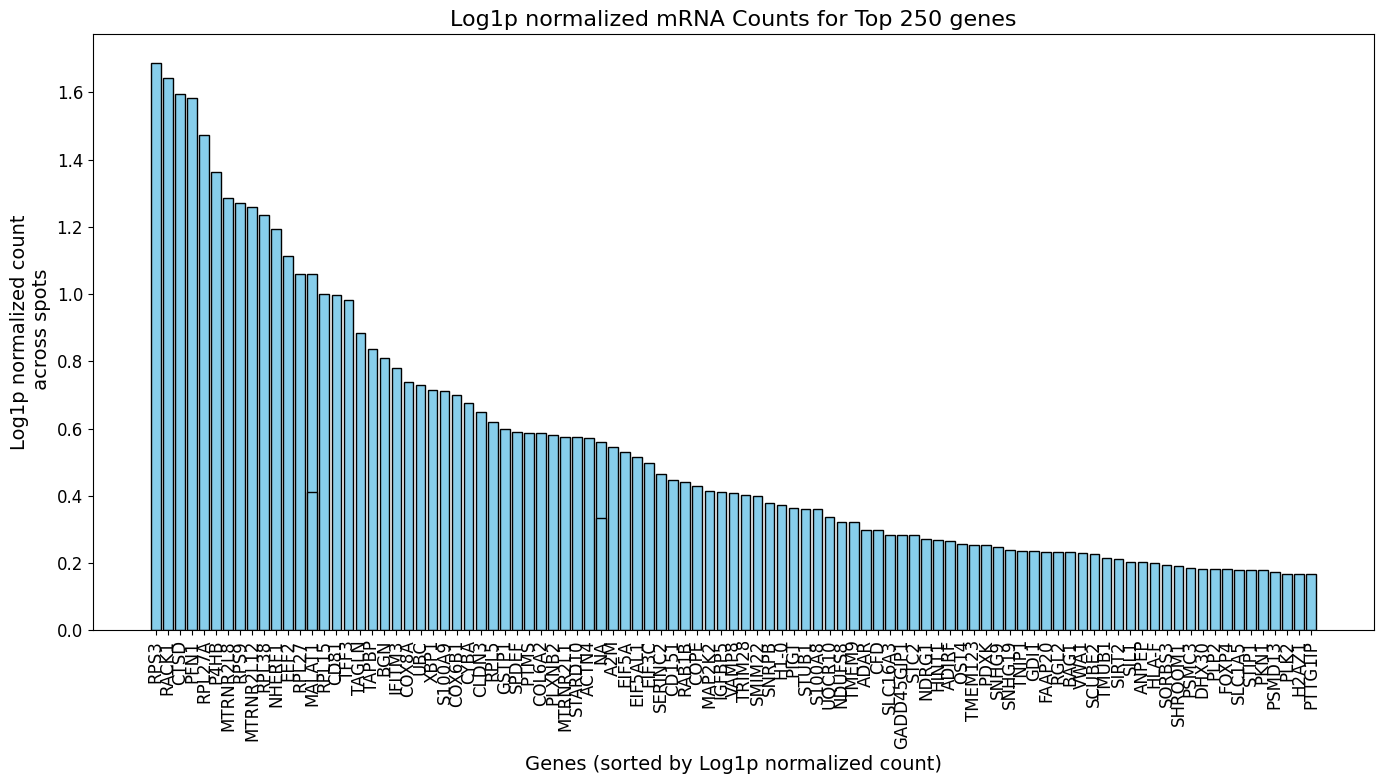

<Figure size 640x480 with 0 Axes>

In [142]:
import matplotlib.pyplot as plt
# mean counts of 250 genes across spots
gene_means_df = pd.DataFrame({'gene': adata_subset.var_names, 'mean_count':  np.mean(adata_subset.X, axis=0)})
gene_means_df_sorted = gene_means_df.sort_values(by='mean_count', ascending = False)


plt.figure(figsize=(14, 8))
plt.bar(top_250_genes_hgnc[1:100], gene_means_df_sorted['mean_count'], color='skyblue', edgecolor='black')
plt.xlabel('Genes (sorted by Log1p normalized count)')
plt.ylabel('Log1p normalized count\n across spots')
plt.title('Log1p normalized mRNA Counts for Top 250 genes')
plt.xticks(rotation='vertical');

plt.tight_layout()
plt.show()


plt.savefig('bucket/plots/mean_mrna_log_counts_top_100.png', dpi=300)  # Save as PNG with high resolution
plt.savefig('bucket/plots/mean_mrna_log_counts_top_100.svg')
